## Neural Network

This is working now for valid_data. Change this to the correct dataset later then add more samples to this row later:

shap_samples = shap.sample(valid_data_x, 10)

In [7]:
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import shap
from scipy.sparse import load_npz
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import pickle
from sklearn.neural_network import MLPClassifier
import joblib


In [8]:
train_data_x_sparse = load_npz('../data/train_data_x_sparse.npz')
train_data_x_dense = pd.read_csv('../data/train_data_x_dense.csv')
pretest_data_x_sparse = load_npz('../data/pretest_data_x_sparse.npz')
pretest_data_x_dense = pd.read_csv('../data/pretest_data_x_dense.csv')
test_data_x_sparse = load_npz('../data/test_data_x_sparse.npz')
test_data_x_dense = pd.read_csv('../data/test_data_x_dense.csv')

train_data_x = pd.DataFrame(hstack([train_data_x_sparse, csr_matrix(train_data_x_dense.values)]).toarray())
pretest_data_x = pd.DataFrame(hstack([pretest_data_x_sparse, csr_matrix(pretest_data_x_dense.values)]).toarray())
test_data_x = pd.DataFrame(hstack([test_data_x_sparse, csr_matrix(test_data_x_dense.values)]).toarray())
train_data_y = np.ravel(pd.read_csv('../data/train_data_y.csv'))
pretest_data_y = np.ravel(pd.read_csv('../data/pretest_data_y.csv'))
test_data_y = np.ravel(pd.read_csv('../data/test_data_y.csv'))

with open('../data/sparse_matrices_feature_names.pkl', 'rb') as f:
    sparse_matrices_feature_names = pickle.load(f)

all_feature_names = list(sparse_matrices_feature_names) + list(train_data_x_dense.columns)
dense_feature_indices = [all_feature_names.index(feature) for feature in train_data_x_dense.columns]
dense_feature_names = list(train_data_x_dense.columns) # Engineered features
sparse_feature_indices = [all_feature_names.index(feature) for feature in sparse_matrices_feature_names]
sparse_feature_names = list(sparse_matrices_feature_names) # TF-IDF features

In [7]:

ann_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

ann_classifier.fit(train_data_x, train_data_y)

# Save the classifier to a file
joblib.dump(ann_classifier, '../data/ann_classifier.pkl')


Iteration 1, loss = 0.46541811
Iteration 2, loss = 0.35758045
Iteration 3, loss = 0.31152004
Iteration 4, loss = 0.28602864
Iteration 5, loss = 0.26490439
Iteration 6, loss = 0.25035969
Iteration 7, loss = 0.23913189
Iteration 8, loss = 0.23238541
Iteration 9, loss = 0.22325619
Iteration 10, loss = 0.21724562
Iteration 11, loss = 0.20963963
Iteration 12, loss = 0.20217524
Iteration 13, loss = 0.19695439
Iteration 14, loss = 0.19152458
Iteration 15, loss = 0.18635981
Iteration 16, loss = 0.18137581
Iteration 17, loss = 0.17784986
Iteration 18, loss = 0.17312435
Iteration 19, loss = 0.16800195
Iteration 20, loss = 0.16497604
Iteration 21, loss = 0.16046219
Iteration 22, loss = 0.15351146
Iteration 23, loss = 0.15333073
Iteration 24, loss = 0.14798211
Iteration 25, loss = 0.14570486
Iteration 26, loss = 0.14225665
Iteration 27, loss = 0.13842035
Iteration 28, loss = 0.13671084
Iteration 29, loss = 0.13087957
Iteration 30, loss = 0.12865754
Iteration 31, loss = 0.12597161
Iteration 32, los

['ann_classifier.pkl']

In [14]:
# To prevent running out of memory, restart kernel after training and load the classifier from the file

ann_classifier = joblib.load('../data/ann_classifier.pkl')


In [10]:
train_data_f1_score = f1_score(train_data_y, ann_classifier.predict(train_data_x))
pretest_data_f1_score = f1_score(pretest_data_y, ann_classifier.predict(pretest_data_x))
test_data_f1_score = f1_score(test_data_y, ann_classifier.predict(test_data_x))

print(f"{'':<20s}{'|':<12s}{'ANN':<23s}{'|'}")
print(f"{'-' * 20}{'|'}{'-' * 17}{'+'}{'-' * 16}{'|'}")
print(f"{'F1 score train':<20s}{'|':<15s}{train_data_f1_score:<20.4f}{'|'}")
print(f"{'F1 score pretest':<20s}{'|':<15s}{pretest_data_f1_score:<20.4f}{'|'}")
print(f"{'F1 score test':<20s}{'|':<15s}{test_data_f1_score:<20.4f}{'|'}")

                    |           ANN                    |
--------------------|-----------------+----------------|
F1 score train      |              0.9867              |
F1 score pretest    |              0.9334              |
F1 score test       |              0.9744              |


In [11]:
# Samples used for calculating SHAP values

shap_samples = shap.sample(test_data_x, 100, random_state=42)
dense_shap_samples = shap_samples.iloc[:, dense_feature_indices]
sparse_shap_samples = shap_samples.iloc[:, sparse_feature_indices]

In [12]:
# Use Shap to explain the model

explainer = shap.KernelExplainer(ann_classifier.predict, shap_samples)

shap_values = explainer.shap_values(shap_samples, num_workers=8)
dense_shap_values = shap_values[:, dense_feature_indices]
sparse_shap_values = shap_values[:, sparse_feature_indices]

  0%|          | 0/100 [00:00<?, ?it/s]

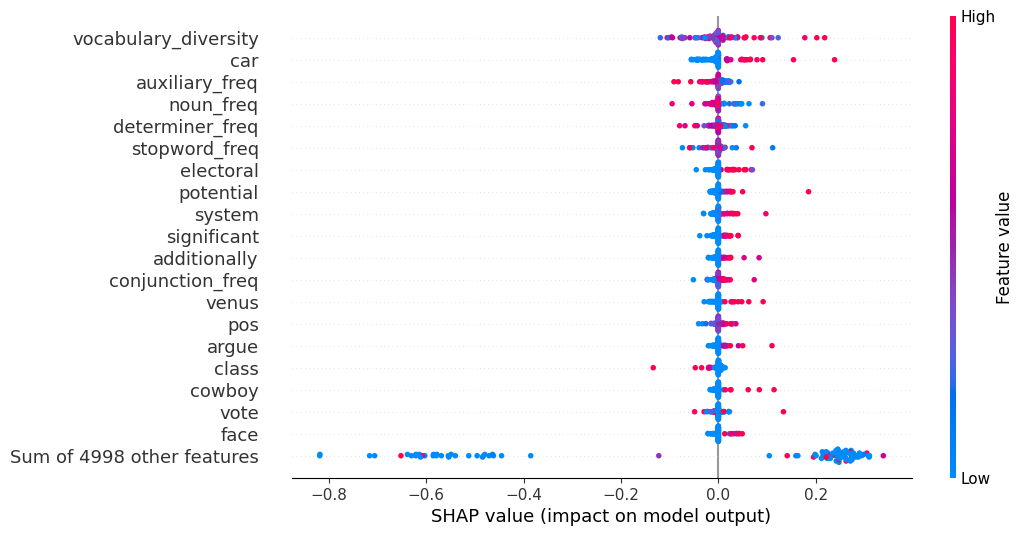

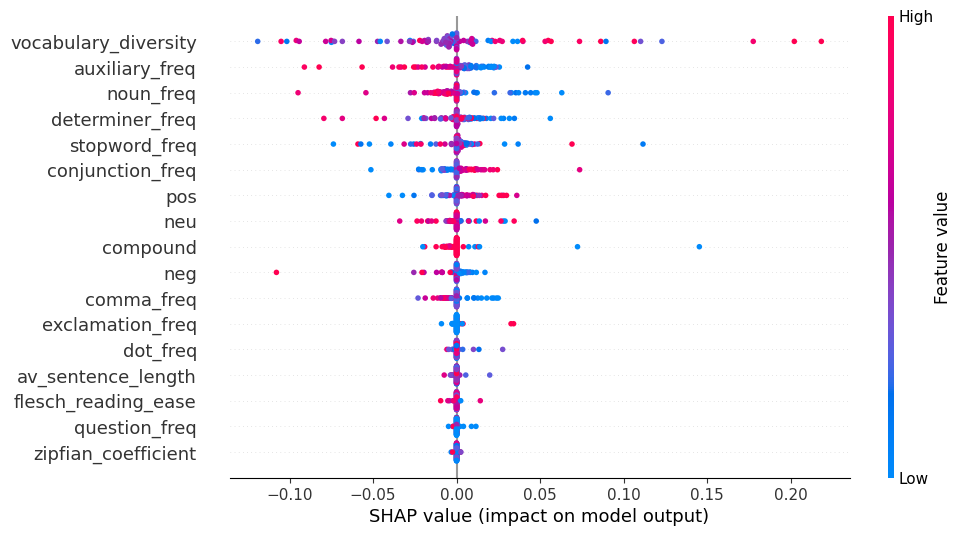

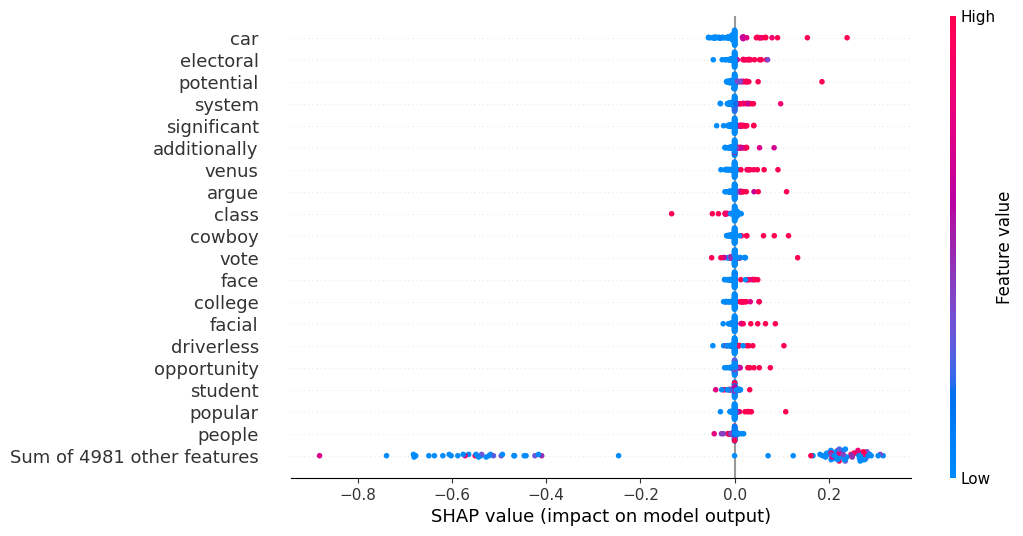

In [13]:
# Visualizing feature importance through beeswarm plots

shap.plots.beeswarm(
    shap.Explanation(values=shap_values, data=shap_samples, feature_names=all_feature_names),
    max_display=20,
    plot_size=(10, 6)
)

shap.plots.beeswarm(
    shap.Explanation(values=dense_shap_values, data=dense_shap_samples, feature_names=dense_feature_names),
    max_display=20,
    plot_size=(10, 6)
)

shap.plots.beeswarm(
    shap.Explanation(values=sparse_shap_values, data=sparse_shap_samples, feature_names=sparse_feature_names),
    max_display=20,
    plot_size=(10, 6)
)